Importamos las librerias necesarias

In [21]:
%run helper.ipynb

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Realizo un análisis exploratorio d ela base de datos con la que voy a trabajar.

Comienzo imprimiendo una imagen aleatoria.

<function matplotlib.pyplot.show(close=None, block=None)>

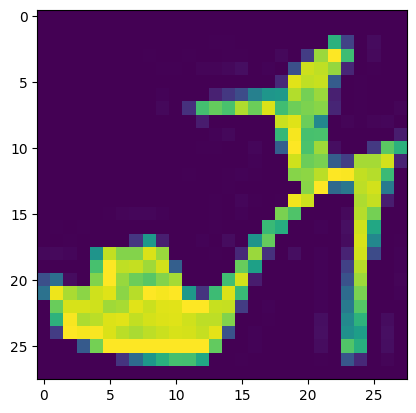

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_imgs[9,...])
plt.show

Luego separo el dataset en una lista de lista que divide a las imagenes por categoría

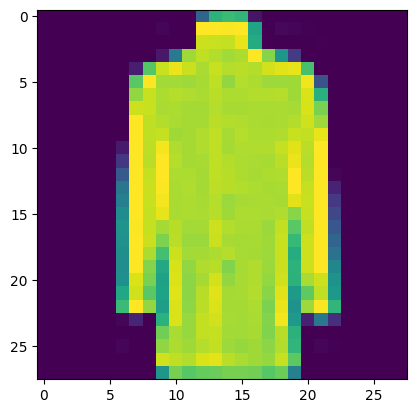

In [5]:
#Imprimo un coat (el sexto de la clase) para verificar
plt.imshow(datasets[4][6])

Hago histogramas para la iluminación de los pixeles de las diferentes categorias de prendas. Aqui vemos que hay mucho espacio de las imágenes en negro, y que por lo demás la forma de las distibuciones es similar, excepto por los diferentes tipos d ezapatos que parecen tener mucho más espacio oscuro de la imágen. 

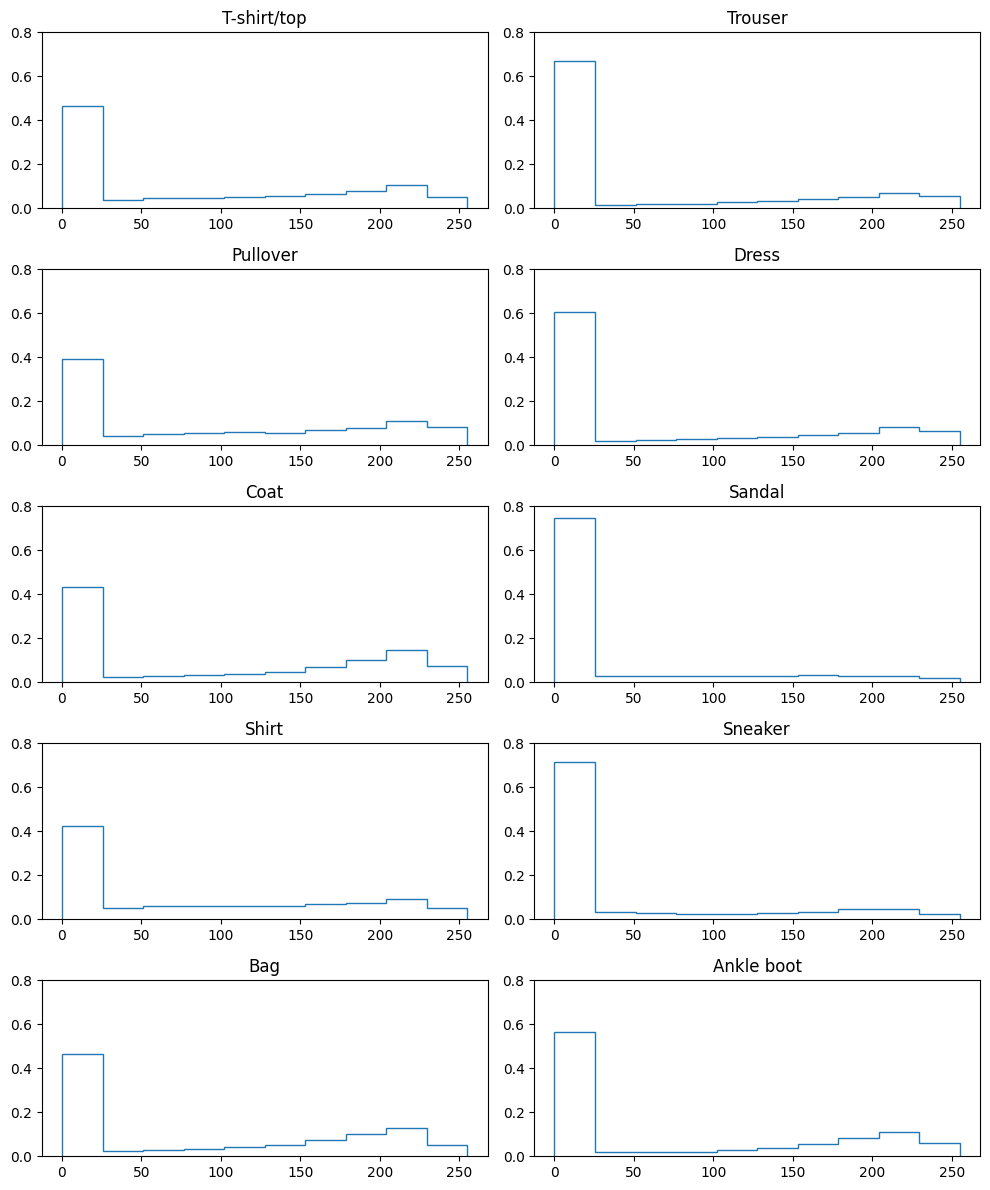

In [14]:
plot_histograms()

Luego realizo una serie de imágenes promedio de cada categoría de prenda.

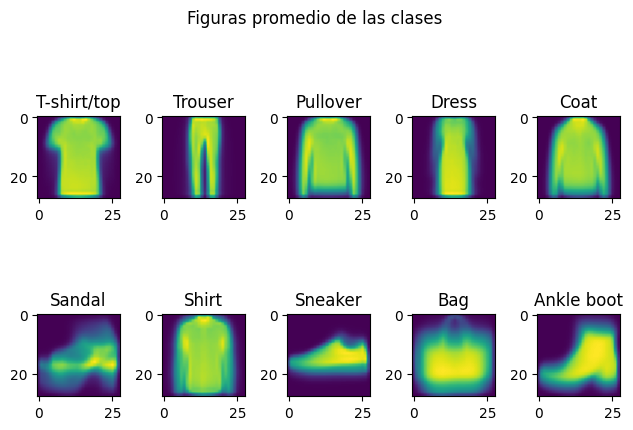

In [22]:
print_average_items()

Separacion entre train y validación, data augmentation. Para esto último opté por sumar al dataset de training las imagenes flipeadas horizontalmente, ya que es simple de lograr y agrega cierta varianza extra al no ser la mayoría de las prendas exactamente simétricas horizontalmente.

In [24]:
from sklearn.model_selection import train_test_split

labels= np.array(train_labels['label'])
train_imgs = np.load('train_images.npy')
X_train, X_val, y_train, y_val = train_test_split(train_imgs, labels, test_size=0.1, random_state=50)

flipped = np.flip(X_train, axis=2)
X_train = np.concatenate((X_train, flipped), axis=0)
y_train = np.concatenate((y_train,y_train), axis=0)

y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)


Modelo softmax

In [26]:
softmax_model = create_softmax_model(output_size = 10)

t_loss, t_accuracy = softmax_model.evaluate(X_train, y_train_categorical)
print('test loss: ', t_loss,'test accuracy: ', t_accuracy)

v_loss, v_accuracy = softmax_model.evaluate(X_val, y_val_categorical)
print('validation loss: ', v_loss,'validation accuracy: ',v_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 salida (Dense)              (None, 10)                7850      
                                                                 
Total params: 10,986
Trainable params: 9,418
Non-trainable params: 1,568
_________________________________________________________________
3375/3375 [==============================] - 14s 4ms/step - loss: 0.4718 - accuracy: 0.8397
test loss:  0.47175225615501404 test accuracy:  0.8396944403648376
188/188 [==============================] - 1s 4ms/step - loss: 0.4780 - accuracy: 0.8378

La validation accuracy es de 0.838, lo que sobrepasa cómodamente lo requerido por la consigna y representa un piso sorprendentemente elevado de performance.

Modelo MPL

Proponemos un modelo simple (solo una hidden layer) para ejecutar la variedad de benchmarks requeridos en un tiempo razonable.
Su performance es muy buena, siendo su validation accuracy 0.893, como se ve más abajo.

In [56]:

_, model = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
opt=optimizers.Adam(learning_rate=0.001, decay=1E-4), 
b_s=2048, 
act='relu', 
pat=10, 
init=keras.initializers.GlorotNormal)

model.summary()

t_loss, t_accuracy = model.evaluate(X_train, y_train_categorical)
print('test loss: ', t_loss,'test accuracy: ', t_accuracy)

v_loss, v_accuracy = model.evaluate(X_val, y_val_categorical)
print('validation loss: ', v_loss,'validation accuracy: ',v_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 middle1 (Dense)             (None, 500)               392500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 middle2 (Dense)             (None, 200)               100200    
                                                                 
 salida (Dense)              (None, 10)                2

A continuacion se prueba la performance con diferentes batch sizes. Se comprueba que la performance parece disminuir al aumentar el tamaño del batch size. Además, a mayor el batch size, mayor la cantidad de epochs necesarias para que el modelo converja. 

In [57]:
batch_sizes = [2**9, 2**11, 2**12, 2**13]
accuracy_values = []
for batch_size in batch_sizes:
    acc_val_hist, _ = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
    opt=optimizers.Adam(learning_rate=0.001, decay=1E-4), 
    b_s=batch_size, 
    act='relu', 
    pat=10, 
    init=keras.initializers.GlorotNormal)
    accuracy_values.append(acc_val_hist)


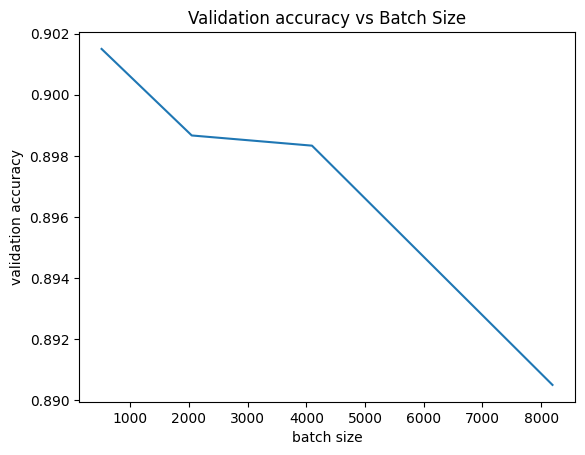

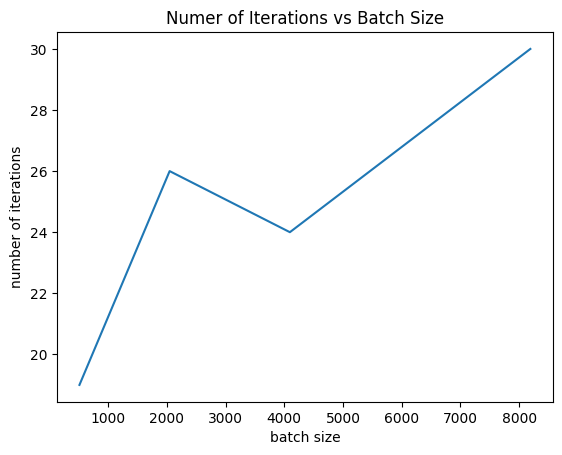

In [58]:
make_batch_size_graphs()

In [59]:
learning_rates = [0.0001, 0.001, 0.01 ,0.1]
accuracy_values = []

for learning_rate in learning_rates:

    acc_val_hist, _ = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
    opt=optimizers.SGD(learning_rate=learning_rate), 
    b_s=2500, 
    act='relu', 
    pat=10, 
    init=keras.initializers.GlorotNormal)
    accuracy_values.append(acc_val_hist)


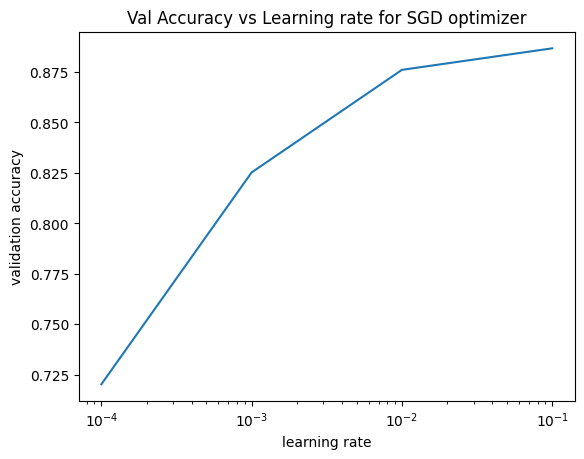

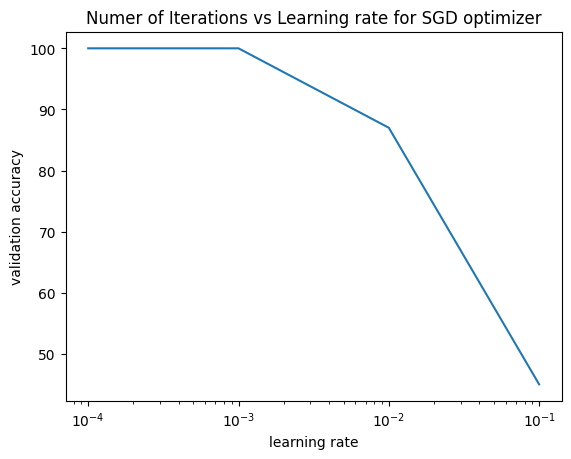

In [60]:
make_learning_rate_graphs()

In [61]:

my_optimizers = [optimizers.SGD(learning_rate=0.05), optimizers.Adam(learning_rate=0.001),optimizers.Adamax(learning_rate=0.001),optimizers.Nadam(learning_rate=0.001)]
accuracy_values = [ ]

for optimizer in my_optimizers:
    acc_val_hist, _ = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
    opt=optimizer, 
    b_s=2500, 
    act='relu', 
    pat=5, 
    init=keras.initializers.GlorotNormal)
    accuracy_values.append(acc_val_hist)



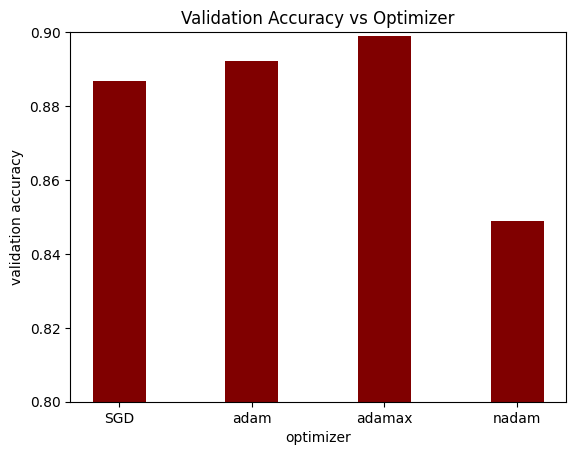

Text(0.5, 1.0, 'Numer of Iterations vs Optimizer')

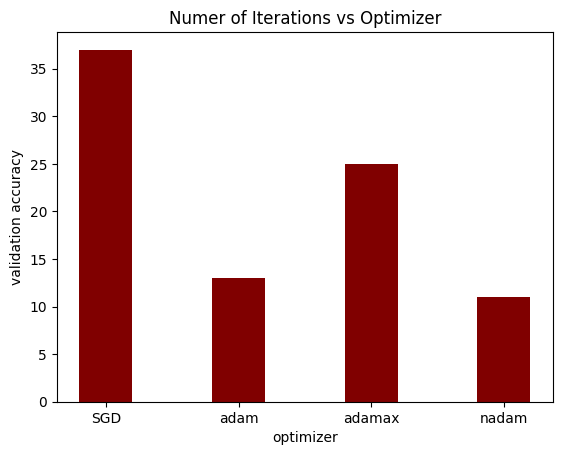

In [62]:
make_optimizer_graphs()

In [63]:
activations = ['relu', 'tanh', 'sigmoid', 'softplus']
accuracy_values = [ ]

for activation in activations:

    acc_val_hist, _ = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
    opt=optimizers.Adam(learning_rate=0.001, decay=1e-4), 
    b_s=2500, 
    act=activation, 
    pat=10, 
    init=keras.initializers.GlorotNormal)
    accuracy_values.append(acc_val_hist)


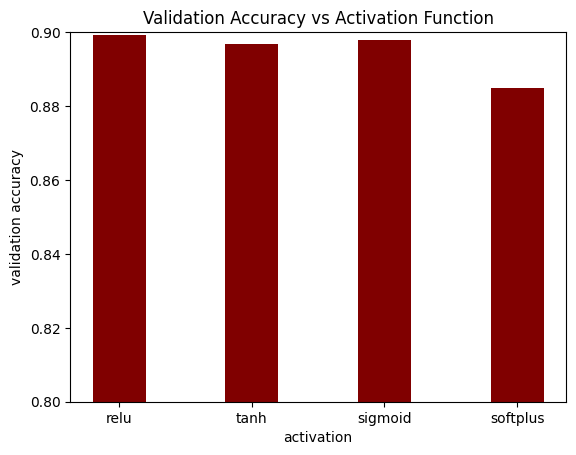

Text(0.5, 1.0, 'Number of Iterations vs Activation Function')

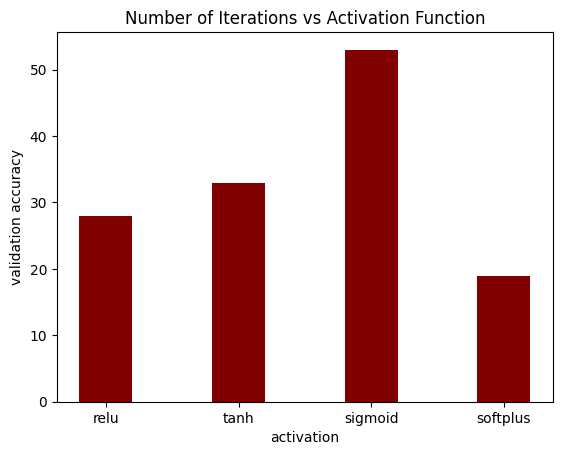

In [64]:
make_activation_graphs()

In [65]:
initializtions = [keras.initializers.RandomNormal(mean=0., stddev=.1, seed=34),
                  keras.initializers.RandomNormal(mean=0., stddev=1., seed=56), 
                  keras.initializers.GlorotNormal, 
                  keras.initializers.GlorotUniform]
accuracy_values = [ ]

for initialization in initializtions:
    acc_val_hist, _ = train_model(X_train, y_train_categorical, X_val, y_val_categorical,
    opt=optimizers.Adam(learning_rate=0.001, decay=1e-4), 
    b_s=2500, 
    act=activation, 
    pat=10, 
    init=initialization)
    accuracy_values.append(acc_val_hist)


C:\Users\joaco\AppData\Roaming\Python\Python310\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


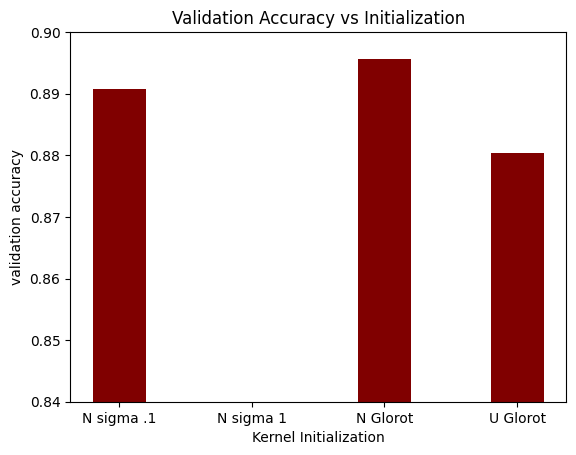

Text(0.5, 1.0, 'Number of Iterations vs Initialization')

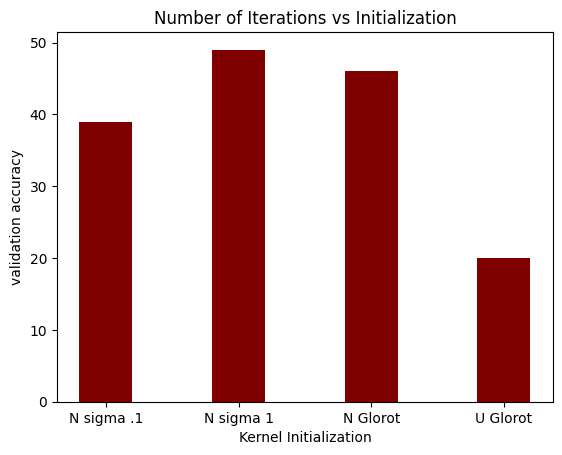

In [66]:
make_initializer_graphs()

Lottery Ticket

In [ ]:


output_size = 10
normal_initializer = keras.initializers.GlorotNormal
uniform_initializer = keras.initializers.GlorotUniform

K.clear_session()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))

model.add(BatchNormalization())
model.add(Dense(500, activation='relu', kernel_initializer=normal_initializer, name='middle0'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu', kernel_initializer=normal_initializer, name='middle1'))
model.add(Dropout(0.2))
model.add(Dense(500, kernel_initializer=normal_initializer, name='middle2'))
model.add(BatchNormalization())
model.add(Dense(500, activation='relu', kernel_initializer=normal_initializer, name='middle3'))
model.add(Dropout(0.2))
model.add(Dense(output_size, activation='softmax',  kernel_initializer=normal_initializer, name='salida'))
model.summary()

import time
adam = optimizers.Adam(learning_rate=0.001, decay=1E-4) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='mpl.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')

earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.save('model_without_training')




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 middle0 (Dense)             (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 middle1 (Dense)             (None, 500)               250500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                        

C:\Users\joaco\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


INFO:tensorflow:Assets written to: model_without_training\assets


In [ ]:
model.fit(X_train, 
          y_train_categorical ,
          epochs=200, batch_size=2048, 
          verbose=0, 
          validation_data=(X_val, y_val_categorical), 
          callbacks=[checkpointer, earlyStopping],
         )
model.save('trained_model')


Epoch 1: val_accuracy improved from -inf to 0.78533, saving model to mpl.mnist.hdf5

Epoch 2: val_accuracy improved from 0.78533 to 0.87233, saving model to mpl.mnist.hdf5

Epoch 3: val_accuracy improved from 0.87233 to 0.88533, saving model to mpl.mnist.hdf5

Epoch 4: val_accuracy improved from 0.88533 to 0.88883, saving model to mpl.mnist.hdf5

Epoch 5: val_accuracy improved from 0.88883 to 0.89250, saving model to mpl.mnist.hdf5

Epoch 6: val_accuracy improved from 0.89250 to 0.89683, saving model to mpl.mnist.hdf5

Epoch 7: val_accuracy did not improve from 0.89683

Epoch 8: val_accuracy improved from 0.89683 to 0.89833, saving model to mpl.mnist.hdf5

Epoch 9: val_accuracy improved from 0.89833 to 0.90017, saving model to mpl.mnist.hdf5

Epoch 10: val_accuracy did not improve from 0.90017

Epoch 11: val_accuracy improved from 0.90017 to 0.90117, saving model to mpl.mnist.hdf5

Epoch 12: val_accuracy did not improve from 0.90117

Epoch 13: val_accuracy improved from 0.90117 to 0.9

In [ ]:
K.clear_session()
model_wo_training = keras.models.load_model("model_without_training")
model_w_training = keras.models.load_model("trained_model")



initial_weights = model_wo_training.get_weights()
final_weights = model_w_training.get_weights()

weight_diff = [np.abs(initial - final) for initial, final in zip(initial_weights, final_weights)]


flattened_diff = np.concatenate([arr.flatten() for arr in weight_diff])
sorted_indices = np.argsort(flattened_diff)[::-1]


threshold_index = int(len(sorted_indices) * 0.5)
threshold = flattened_diff[sorted_indices[threshold_index]]


modified_weights = []
for initial, final in zip(initial_weights, final_weights):
    mask = np.abs(final - initial) >= threshold
    modified_weights.append(np.where(mask, initial, 0.0))



final_model = keras.models.load_model("model_without_training")
final_model.set_weights(modified_weights)



In [ ]:

adam = optimizers.Adam(learning_rate=0.001, decay=1E-4) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='mpl.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
#final_model = keras.models.load_model("model_without_training")
#final_model.set_weights(modified_weights)



final_model.fit(X_train, 
          y_train_categorical ,
          epochs=200, batch_size=2048, 
          verbose=0, 
          validation_data=(X_val, y_val_categorical), 
          callbacks=[checkpointer, earlyStopping],
         )



Epoch 1: val_accuracy improved from -inf to 0.90767, saving model to mpl.mnist.hdf5

Epoch 2: val_accuracy did not improve from 0.90767

Epoch 3: val_accuracy improved from 0.90767 to 0.90783, saving model to mpl.mnist.hdf5

Epoch 4: val_accuracy improved from 0.90783 to 0.91083, saving model to mpl.mnist.hdf5

Epoch 5: val_accuracy did not improve from 0.91083

Epoch 6: val_accuracy did not improve from 0.91083

Epoch 7: val_accuracy did not improve from 0.91083

Epoch 8: val_accuracy did not improve from 0.91083

Epoch 9: val_accuracy did not improve from 0.91083

Epoch 10: val_accuracy did not improve from 0.91083

Epoch 11: val_accuracy did not improve from 0.91083

Epoch 12: val_accuracy did not improve from 0.91083

Epoch 13: val_accuracy did not improve from 0.91083

Epoch 14: val_accuracy did not improve from 0.91083

Epoch 15: val_accuracy did not improve from 0.91083

Epoch 16: val_accuracy did not improve from 0.91083

Epoch 17: val_accuracy did not improve from 0.91083

Ep

In [ ]:
x_test = np.load('test_images.npy')
y_test = final_model.predict(x_test)
labels = np.array([np.argmax(prediction) for prediction in y_test])
submission=pd.DataFrame({"id": np.arange(10000) , "Category" : labels})
submission.to_csv("submission4bis.csv",index=False)

313/313 [==============================] - 1s 3ms/step


In [ ]:
x_test = np.load('test_images.npy')
y_test = model.predict(x_test)
labels = np.array([np.argmax(prediction) for prediction in y_test])
submission=pd.DataFrame({"id": np.arange(10000) , "Category" : labels})
submission.to_csv("submission.csv",index=False)

Problema de Regresión

In [87]:
from tensorflow.keras.datasets import mnist
import pandas as pd
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")

In [88]:
train_morpho

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523
...,...,...,...,...,...,...,...
59995,59995,102.1875,61.415999,1.941380,0.366472,11.840672,19.937599
59996,59996,108.5625,46.705844,2.538071,0.364359,13.325950,19.688557
59997,59997,87.0625,44.523864,2.058077,0.257784,14.133500,20.070647
59998,59998,82.2500,53.337572,1.667193,0.310377,15.251961,19.692976


In [1]:


total_df = pd.concat([train_morpho, pd.DataFrame({'label': y_train})], axis=1)
grouped_df = total_df.groupby('label')

# Iterate over each group and plot the histogram for column "B"
for category, group in grouped_df:
    plt.hist(group['slant'], bins=10)  # Adjust the number of bins as needed
    plt.title(f"Histogram of Column B for Category {category}")
    plt.xlabel("")
    plt.ylabel("Frequency")
    plt.show()

NameError: name 'pd' is not defined

In [91]:
for item in train_morpho.keys():
    print('correlation between '+item+ 'and slant is: ', train_morpho['slant'].corr(train_morpho[item]))

correlation between indexand slant is:  -0.006514073348763724
correlation between areaand slant is:  -0.005367359748599988
correlation between lengthand slant is:  -0.020269380801968277
correlation between thicknessand slant is:  0.00705162584853723
correlation between slantand slant is:  1.0
correlation between widthand slant is:  -0.15834194904399065
correlation between heightand slant is:  -0.14276048322572704


In [105]:

normal_initializer = keras.initializers.GlorotNormal
uniform_initializer = keras.initializers.GlorotUniform

K.clear_session()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))

model.add(BatchNormalization())
model.add(Dense(500, activation='relu', kernel_initializer=normal_initializer, name='middle0'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu', kernel_initializer=normal_initializer, name='middle1'))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu', kernel_initializer=normal_initializer, name='middle2'))
model.add(Dense(1, name='salida'))
model.summary()

earlyStopping = keras.callbacks.EarlyStopping(
    monitor="mae",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model.compile(loss = 'mean_squared_error', optimizer=optimizers.Adam(learning_rate=0.001, decay=1E-4), metrics=['mae'])


model.fit(x_train, 
          np.array(train_morpho['slant']),
          epochs=200, batch_size=2048, 
          verbose=1, 
          validation_data=(x_test, np.array(test_morpho['slant'])), 
          callbacks=[earlyStopping],
         )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 middle0 (Dense)             (None, 500)               392500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 middle1 (Dense)             (None, 200)               100200    
                                                                 
 batch_normalization_1 (Batc  (None, 200)              800       
 hNormalization)                                        